In [ ]:
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import io
from google.colab import files
from google.colab import drive
from sklearn.model_selection import train_test_split
import pandas as pd
import yfinance as yf
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
uploaded = files.upload()

Saving SP600_AdjClose_Volume_Return.csv to SP600_AdjClose_Volume_Return (1).csv


In [ ]:
df = pd.read_csv('SP600_AdjClose_Volume_Return.csv')
df.head()

,Date,Adj Close,Volume,Ticker,Return
0,2019-09-30,150.984802,982800,AAP,NaN
1,2019-10-01,152.710114,1086300,AAP,0.011427
2,2019-10-02,148.757462,975400,AAP,-0.025883
3,2019-10-03,145.927643,918100,AAP,-0.019023
4,2019-10-04,146.000671,749000,AAP,0.000500


In [ ]:
df['Return'] = df['Return'].fillna(0)

In [ ]:

window_size = 10

# Calculate the rolling mean and standard deviation for 'Return'
df['Return_Rolling_Mean'] = df['Return'].rolling(window=window_size).mean()
df['Return_Rolling_Std'] = df['Return'].rolling(window=window_size).std()

threshold_factor = 2 # Adjust as needed

# Label anomalies based on the deviation from the mean, using the standard deviation
df['Return_Anomaly'] = np.where((np.abs(df['Return'] - df['Return_Rolling_Mean']) > threshold_factor * df['Return_Rolling_Std']), 1, 0)

# Check the counts of anomalies detected based on rolling mean
print("Return Anomalies Detected (Rolling Mean and Std):\n", df['Return_Anomaly'].value_counts())

Return Anomalies Detected (Rolling Mean and Std):
 Return_Anomaly
0    710654
1     25745
Name: count, dtype: int64


In [ ]:
df

,Date,Adj Close,Volume,Ticker,Return,Return_Rolling_Mean,Return_Rolling_Std,Return_Anomaly
0,2019-09-30,150.984802,982800,AAP,0.000000,NaN,NaN,0
1,2019-10-01,152.710114,1086300,AAP,0.011427,NaN,NaN,0
2,2019-10-02,148.757462,975400,AAP,-0.025883,NaN,NaN,0
3,2019-10-03,145.927643,918100,AAP,-0.019023,NaN,NaN,0
4,2019-10-04,146.000671,749000,AAP,0.000500,NaN,NaN,0
...,...,...,...,...,...,...,...,...
736394,2024-09-23,34.169998,1511400,ZWS,-0.019231,0.006701,0.016196,0
736395,2024-09-24,34.669998,988700,ZWS,0.014633,0.005914,0.015521,0
736396,2024-09-25,34.700001,1020700,ZWS,0.000865,0.007895,0.013064,0
736397,2024-09-26,35.090000,940600,ZWS,0.011239,0.007836,0.013045,0


# Model1

In [ ]:
# model1
feature_columns = ['Adj Close', 'Volume', 'Return_Rolling_Mean']
X = df[feature_columns].values  # Features for the model

# Using the labeled data for supervised learning
y_return = df['Return_Anomaly'].values  # Target for return anomalies

In [ ]:
# Split into training and test sets for return anomalies
X_train_return, X_test_return, y_train_return, y_test_return = train_test_split(X, y_return, test_size=0.2, random_state=42, stratify=y_return)
# Train the Random Forest model for return anomalies
rf_model_return = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model_return.fit(X_train_return, y_train_return)

# Make predictions for return anomalies
y_pred_return = rf_model_return.predict(X_test_return)

# Evaluate the model for return anomalies
print("Return Anomalies Random Forest Model (Supervised):")
print("Accuracy:", accuracy_score(y_test_return, y_pred_return))
print("Confusion Matrix:\n", confusion_matrix(y_test_return, y_pred_return))
print("Classification Report:\n", classification_report(y_test_return, y_pred_return))

Return Anomalies Random Forest Model (Supervised):
Accuracy: 0.964951113525258
Confusion Matrix:
 [[142112     19]
 [  5143      6]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98    142131
           1       0.24      0.00      0.00      5149

    accuracy                           0.96    147280
   macro avg       0.60      0.50      0.49    147280
weighted avg       0.94      0.96      0.95    147280



# Model2

In [ ]:
# features
df['Volume_Rolling_Std'] = df['Volume'].rolling(window=window_size).std()
df['Return_Rolling_Skew'] = df['Return'].rolling(window=window_size).skew()
df['Return_Rolling_Kurt'] = df['Return'].rolling(window=window_size).kurt()
df['SMA_20'] = df['Adj Close'].rolling(window=20).mean()
df['EMA_20'] = df['Adj Close'].ewm(span=20, adjust=False).mean()
df['Momentum'] = df['Adj Close'].diff(window_size)

In [ ]:
feature_columns = ['Adj Close', 'Volume', 'Return_Rolling_Mean',
                   'Volume_Rolling_Std', 'Return_Rolling_Skew',
                   'Return_Rolling_Kurt', 'SMA_20', 'EMA_20', 'Momentum']
X = df[feature_columns].values  # Features for the model

# Using the labeled data for supervised learning
y_return = df['Return_Anomaly'].values  # Target for return anomalies

In [ ]:
# Split into training and test sets for return anomalies
X_train_return, X_test_return, y_train_return, y_test_return = train_test_split(X, y_return, test_size=0.2, random_state=42, stratify=y_return)
# Train the Random Forest model for return anomalies
rf_model_return = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model_return.fit(X_train_return, y_train_return)

# Make predictions for return anomalies
y_pred_return = rf_model_return.predict(X_test_return)

# Evaluate the model for return anomalies
print("Return Anomalies Random Forest Model (Supervised):")
print("Accuracy:", accuracy_score(y_test_return, y_pred_return))
print("Confusion Matrix:\n", confusion_matrix(y_test_return, y_pred_return))
print("Classification Report:\n", classification_report(y_test_return, y_pred_return))

Return Anomalies Random Forest Model (Supervised):
Accuracy: 0.9668318848451928
Confusion Matrix:
 [[141935    196]
 [  4689    460]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98    142131
           1       0.70      0.09      0.16      5149

    accuracy                           0.97    147280
   macro avg       0.83      0.54      0.57    147280
weighted avg       0.96      0.97      0.95    147280



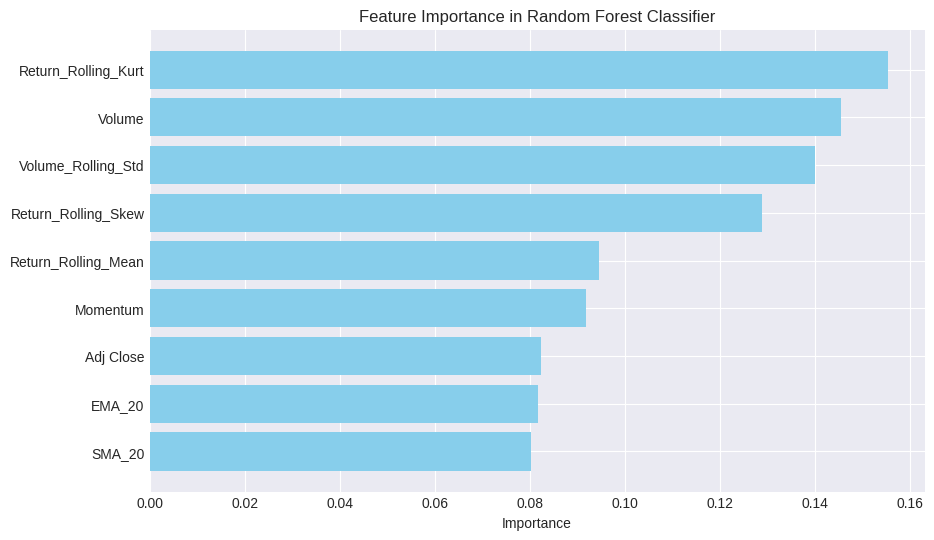

In [ ]:
# Get feature importances
importances = rf_model_return.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance in Random Forest Classifier')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

#model 3

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define your feature columns and target variable as per your setup
feature_columns = ['Adj Close', 'Volume', 'Return_Rolling_Mean',
                   'Volume_Rolling_Std', 'Return_Rolling_Skew',
                   'Return_Rolling_Kurt', 'Momentum']

X = df[feature_columns].values  # Features for the model
y_return = df['Return_Anomaly'].values  # Target for return anomalies

# Drop rows with NaN values in X and align y accordingly
nan_mask = ~np.isnan(X).any(axis=1)
X = X[nan_mask]
y_return = y_return[nan_mask]

X_train, X_test, y_train, y_test = train_test_split(X, y_return, test_size=0.2, random_state=42)
rf_model_return = RandomForestClassifier(random_state=42, n_estimators=100)

rf_model_return.fit(X_train, y_train)
# Make predictions for return anomalies
y_pred_return = rf_model_return.predict(X_test)

# Evaluate the model for return anomalies
print("Return Anomalies Random Forest Model (Supervised):")
print("Accuracy:", accuracy_score(y_test, y_pred_return))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_return))
print("Classification Report:\n", classification_report(y_test, y_pred_return))


Return Anomalies Random Forest Model (Supervised):
Accuracy: 0.9672456171322261
Confusion Matrix:
 [[142033    193]
 [  4631    421]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98    142226
           1       0.69      0.08      0.15      5052

    accuracy                           0.97    147278
   macro avg       0.83      0.54      0.57    147278
weighted avg       0.96      0.97      0.95    147278



# Visualize

<ipython-input-44-42424b3d5491>:30: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


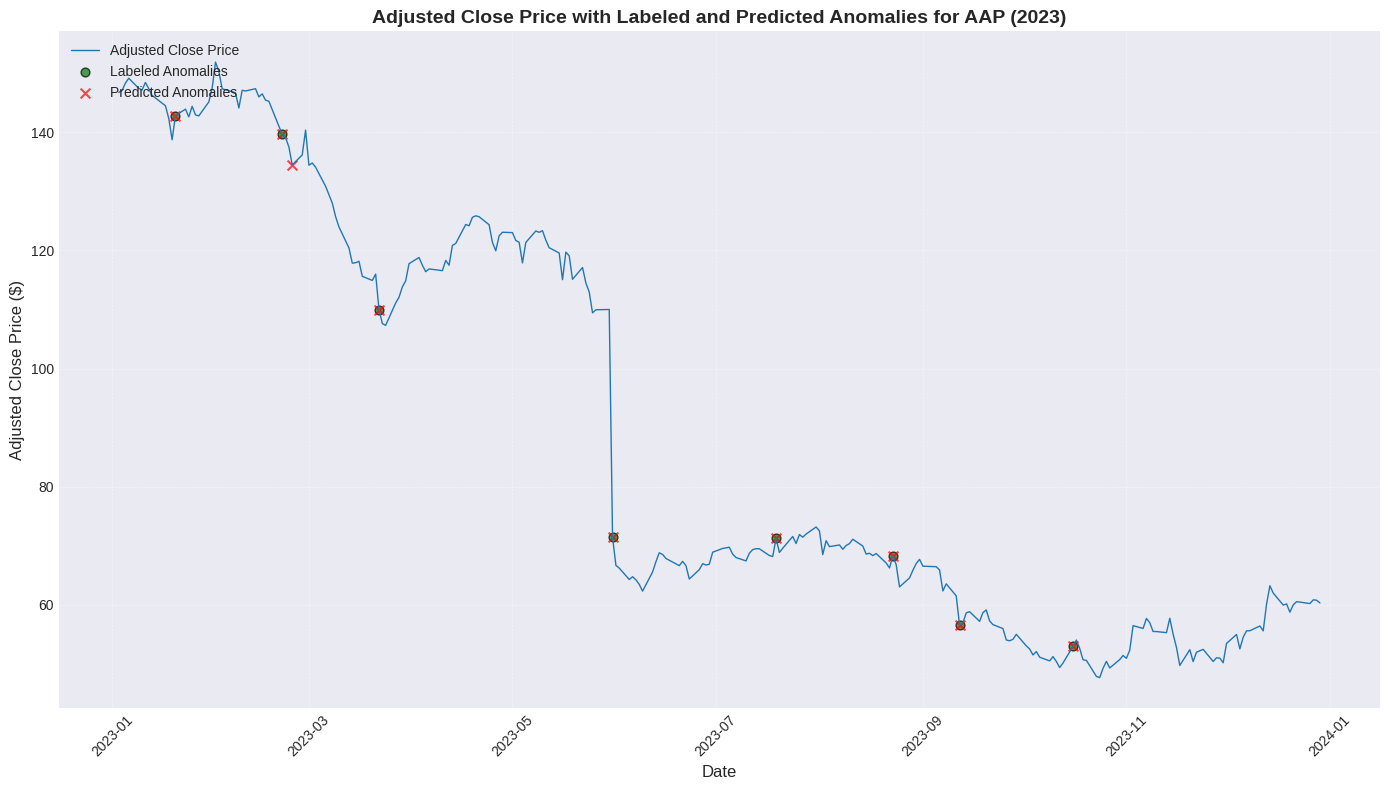

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Ensure the 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Filter the DataFrame for the stock "AAP" and the year 2023
df_aap = df[(df['Ticker'] == 'AAP') & (df['Date'].dt.year == 2023)]

# Prepare the features for the model (ensure alignment with your setup)
X_aap = df_aap[feature_columns].values

# Drop rows with NaN values in X and align the filtered DataFrame accordingly
nan_mask = ~np.isnan(X_aap).any(axis=1)
X_aap = X_aap[nan_mask]
df_aap_filtered = df_aap[nan_mask]  # Filter df_aap to keep only rows with non-NaN values

# Use the trained model to predict anomalies for "AAP"
y_pred_aap = rf_model_return.predict(X_aap)

# Add the predicted anomalies to the filtered DataFrame
df_aap_filtered['Predicted_Anomaly'] = y_pred_aap

# Create the plot with labeled and predicted anomalies
plt.figure(figsize=(14, 8))
plt.style.use('seaborn-darkgrid')

# Plot the adjusted close price
plt.plot(df_aap_filtered['Date'], df_aap_filtered['Adj Close'], label='Adjusted Close Price', color='#1f77b4', linewidth=1)

# Highlight the labeled anomalies (Return_Anomaly) for 2023
labeled_anomalies = df_aap_filtered[df_aap_filtered['Return_Anomaly'] == 1]
plt.scatter(labeled_anomalies['Date'], labeled_anomalies['Adj Close'],
            color='green', label='Labeled Anomalies', marker='o', edgecolor='black', s=40, alpha=0.7)

# Highlight the predicted anomalies for 2023
predicted_anomalies = df_aap_filtered[df_aap_filtered['Predicted_Anomaly'] == 1]
plt.scatter(predicted_anomalies['Date'], predicted_anomalies['Adj Close'],
            color='red', label='Predicted Anomalies', marker='x', s=50, alpha=0.7)

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Adjusted Close Price ($)', fontsize=12)
plt.title('Adjusted Close Price with Labeled and Predicted Anomalies for AAP (2023)', fontsize=14, weight='bold')
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
plt.xticks(rotation=45)

# Ensure layout is tight
plt.tight_layout()

# Show the plot
plt.show()
